# Implémentation de l'algorithme SCP

### Introduction

Ce notebook implémente la méthode **SCP (Split Conformal Prediction)** adaptée aux problèmes de classification.Contrairement à la régression où l'on cherche à prédire un intervalle continu $[y_{min}, y_{max}]$, l'objectif ici est de construire un ensemble de prédiction $\Gamma(x)$ (une liste de classes) susceptible de contenir la vraie classe.

### Le défi de l'incertitude en classification
Dans une classification multi-classe standard, le modèle renvoie souvent la classe ayant la probabilité la plus élevée. Cependant, si un modèle prédit "Sapin" avec 35% de probabilité et "Pin" avec 34%, choisir uniquement "Sapin" est risqué.

La méthode SCP permet de transformer ces probabilités brutes en un ensemble de classes $\{ \text{Sapin, Pin} \}$ garantissant que la vraie classe s'y trouve avec une probabilité $1-\alpha$.

### Méthode "Threshold" (Naive SCP)
L'approche implémentée ici est la version "Threshold" :
1.  On calcule les probabilités pour chaque classe.
2.  On définit un score de non-conformité basé sur la probabilité de la vraie classe : $s_i = 1 - \hat{\pi}(y_i|x_i)$.
3.  Sur l'ensemble de calibration, on trouve le seuil critique $\hat{q}$ tel que 99% des vraies classes ont une probabilité $1 - s_i \ge 1 - \hat{q}$.
4.  Pour une nouvelle prédiction, on inclut dans l'ensemble final toutes les classes dont la probabilité dépasse ce seuil.

### Chargement des données

In [ ]:
import polars as pl
import numpy as np

# Polars display options
pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(2)

# Load preprocessed data
df = pl.read_parquet("../../data/forest_cover_clean.parquet")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (581012, 13)


Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,_Soil_Type,_Wilderness_Area
2596,51,3,258,0,510,221,232,148,6279,5,"""28""","""0"""
2590,56,2,212,-6,390,220,235,151,6225,5,"""28""","""0"""
2804,139,9,268,65,3180,234,238,135,6121,2,"""11""","""0"""
2785,155,18,242,118,3090,238,238,122,6211,2,"""29""","""0"""
2595,45,2,153,-1,391,220,234,150,6172,5,"""28""","""0"""


### Séparation des données

In [64]:
from sklearn.model_selection import train_test_split

y = df.drop_in_place("Cover_Type")
X = df

# 60% train, 20% calibration, 20% test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size (60%): {X_train.shape[0]}")
print(f"Calibration set size (20%): {X_calib.shape[0]}")
print(f"Test set size (20%): {X_test.shape[0]}")

Train set size (60%): 348607
Calibration set size (20%): 116202
Test set size (20%): 116203


### Définition du modèle

Au regard de la taille du dataset et du temps d'entraînement ($\approx 1$ minute), nous n'allons pas optimiser les hyperparamètres.

In [65]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.1,
    max_iter=2000,
    max_depth=None,
    max_leaf_nodes=127,
    min_samples_leaf=50,
    l2_regularization=0.5,
    categorical_features="from_dtype",
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    class_weight="balanced",  # Covertype classes are heavily imbalanced
    random_state=42,
)

model.fit(X_train, y_train);

### Évaluation du modèle de base

In [66]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42218
           2       0.96      0.94      0.95     56895
           3       0.95      0.96      0.96      7075
           4       0.88      0.89      0.88       536
           5       0.81      0.94      0.87      1933
           6       0.89      0.96      0.92      3449
           7       0.95      0.98      0.96      4097

    accuracy                           0.94    116203
   macro avg       0.91      0.94      0.93    116203
weighted avg       0.94      0.94      0.94    116203



Le modèle de base est excellent.

### Implémentation de l'algorithme SCP

Dans le cadre de la classification, la méthode SCP utilise les probabilités prédites par le modèle pour construire un score de non-conformité défini par $s_i = 1 - \hat{\pi}(y_i|x_i)$, où $\hat{\pi}(y_i|x_i)$ est la probabilité estimée de la vraie classe.

L'ensemble de prédiction pour une nouvelle observation $x$ est construit en incluant toutes les classes $k$ telles que $1 - \hat{\pi}(k|x) \le \hat{q}$, où $\hat{q}$ est le quantile $(1-\alpha)$ des scores de non-conformité calculés sur l'ensemble de calibration.

In [67]:
# 1. Predict probabilities on calibration set
y_calib_pred_proba = model.predict_proba(X_calib)
classes = model.classes_

# 2. Compute nonconformity scores (1 - softmax probability of true class)
y_calib_np = y_calib.to_numpy()

# Get the index of the true class for each sample
# We assume classes are mapped to indices 0..K-1 in the proba array
# model.classes_ gives the mapping
class_to_idx = {c: i for i, c in enumerate(classes)}
class_indices = np.array([class_to_idx[y] for y in y_calib_np])

# Extract probabilities of true classes
# y_calib_pred_proba is shape (n_samples, n_classes)
prob_true_class = y_calib_pred_proba[np.arange(len(y_calib)), class_indices]

# Score = 1 - prob_true_class
nonconformity_scores = 1 - prob_true_class

In [68]:
# 3. Compute quantile
alpha = 0.01
n = len(nonconformity_scores)
q_level = np.ceil((n + 1) * (1 - alpha)) / n
qhat = np.quantile(nonconformity_scores, q_level, method="linear")

print(f"SCP calibration qhat (α={alpha}): {qhat:.4f}")

SCP calibration qhat (α=0.01): 0.8516


### Distribution des scores de non-conformité

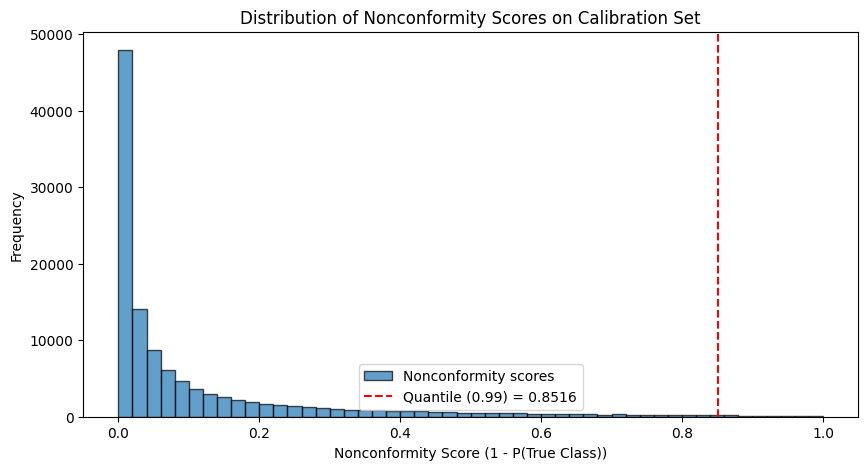

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(
    nonconformity_scores,
    bins=50,
    alpha=0.7,
    edgecolor="k",
    label="Nonconformity scores",
)
plt.axvline(
    qhat, color="red", linestyle="--", label=f"Quantile ({1 - alpha:.2f}) = {qhat:.4f}"
)
plt.xlabel("Nonconformity Score (1 - P(True Class))")
plt.ylabel("Frequency")
plt.title("Distribution of Nonconformity Scores on Calibration Set")
plt.legend()
plt.show()

Les ensembles de prédiction sont construits pour l'ensemble de test.

In [70]:
# 4. Predict on test set
y_test_pred_proba = model.predict_proba(X_test)

# 5. Build prediction sets
# Include class k if 1 - P(y=k|x) <= qhat
prediction_sets = []
for probs in y_test_pred_proba:
    # classes where probability is high enough
    pset = classes[probs >= (1 - qhat)]
    prediction_sets.append(pset)

# Create results DataFrame
df_test_results = pl.DataFrame(
    {
        "True Class": y_test,
        "Prediction Set": prediction_sets,
    }
).with_columns(pl.col("Prediction Set").list.len().alias("Cardinality"))

# Add features for analysis
df_test_full = pl.concat([df_test_results, X_test], how="horizontal")
df_test_full.head()

True Class,Prediction Set,Cardinality,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,_Soil_Type,_Wilderness_Area
1,[1],1,2844,317,29,127,69,3792,131,200,202,5711,"""28""","""0"""
1,[1],1,3037,304,16,0,0,2955,175,230,195,1736,"""23""","""2"""
2,"[2, 5]",2,2727,213,18,95,23,768,201,254,184,2068,"""3""","""2"""
2,[2],1,2854,117,6,90,20,1295,231,234,136,2424,"""30""","""2"""
2,[2],1,2554,348,13,0,0,1593,194,217,161,4569,"""15""","""0"""


### Évaluation des performances

In [71]:
df_test_full.describe()

statistic,True Class,Prediction Set,Cardinality,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,_Soil_Type,_Wilderness_Area
"""count""",116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,"""116203""","""116203"""
"""null_count""",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"""0""","""0"""
"""mean""",2.05,null,1.22,2959.91,155.80,14.11,269.43,46.28,2348.02,212.17,223.37,142.53,1979.56,null,null
"""std""",1.40,null,0.42,279.18,111.83,7.49,212.76,58.22,1556.16,26.74,19.78,38.37,1320.56,null,null
"""min""",1.00,null,1.00,1863.00,0.00,0.00,0.00,-173.00,0.00,0.00,0.00,0.00,0.00,null,null
"""25%""",1.00,null,1.00,2809.00,59.00,9.00,108.00,7.00,1110.00,198.00,213.00,119.00,1024.00,null,null
"""50%""",2.00,null,1.00,2996.00,127.00,13.00,218.00,30.00,1998.00,218.00,226.00,143.00,1712.00,null,null
"""75%""",2.00,null,1.00,3164.00,260.00,18.00,384.00,69.00,3314.00,231.00,237.00,168.00,2551.00,null,null
"""max""",7.00,null,4.00,3856.00,360.00,62.00,1383.00,598.00,7061.00,254.00,254.00,252.00,7145.00,null,null


### Définition des métriques de performances

In [72]:
coverage = (
    pl.col("Prediction Set")
    .list.contains(pl.col("True Class"))
    .mean()
    .mul(100)
    .round(2)
    .alias("Coverage")
)
avg_set_size = pl.col("Cardinality").mean().round(2).alias("Average Cardinality")
singleton_rate = (pl.col("Cardinality") == 1).mean().round(2).alias("Singleton Rate")

print(f"Coverage: {df_test_full.select(coverage).item()}% (target: 99%)")
print(f"Average Cardinality: {df_test_full.select(avg_set_size).item()} elements")
print(f"Singleton Rate: {df_test_full.select(singleton_rate).item()}%")

Coverage: 99.01% (target: 99%)
Average Cardinality: 1.22 elements
Singleton Rate: 0.78%


### Analyse de la couverture par classe

In [73]:
df_test_full.group_by("True Class").agg(
    coverage,
    avg_set_size,
    singleton_rate,
    pl.len().alias("Count"),
).sort("True Class")

True Class,Coverage,Average Cardinality,Singleton Rate,Count
1,99.18,1.23,0.77,42218
2,99.06,1.25,0.75,56895
3,98.56,1.08,0.92,7075
4,92.72,1.09,0.92,536
5,97.41,1.12,0.88,1933
6,98.55,1.10,0.90,3449
7,99.29,1.04,0.96,4097


### Analyse de la couverture par taille d'ensemble

In [74]:
df_test_full.group_by("Cardinality").agg(
    coverage,
    pl.len().alias("Count"),
).sort("Cardinality")

Cardinality,Coverage,Count
1,98.81,91000
2,99.74,24969
3,99.57,232
4,100.00,2
